In [1]:
import dask.dataframe as dd
import contextily as cx
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
filter_string = ' & '.join(
    (
        '(1 <= PULocationID) & (PULocationID <= 263)',
        '(1 <= DOLocationID) & (DOLocationID <= 263)'
    )
)

pre_covid_data = dd.read_parquet(
    path='2019',
    columns=['PULocationID', 'DOLocationID']
)

covid_data = dd.read_parquet(
    path='2020',
    columns=['PULocationID', 'DOLocationID']
)

pre_covid_data = pre_covid_data.query(filter_string)
covid_data = covid_data.query(filter_string)

### Földrajzi adatok beolvasása

In [3]:
data = (
    gpd
    .read_file(
        filename='taxi_zones/taxi_zones.shp',
        ignore_fields=['Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough']
    )
    .set_index('OBJECTID')
    .rename_axis('LocationID')
)

### Körzetadatok összegzése

In [4]:
%%time

pickup_pre_covid = (
    pre_covid_data
    .PULocationID
    .value_counts()
    .compute()
    .reindex_like(data)
)

dropoff_pre_covid = (
    pre_covid_data
    .DOLocationID
    .value_counts()
    .compute()
    .reindex_like(data)
)

pickup_covid = (
    covid_data
    .PULocationID
    .value_counts()
    .compute()
    .reindex_like(data)
)

dropoff_covid = (
    covid_data
    .DOLocationID
    .value_counts()
    .compute()
    .reindex_like(data)
)

CPU times: total: 28.1 s
Wall time: 7.3 s


### Logaritmus vétel és hiányzó adatok kitöltése

In [5]:
data['PUFrequencyPrC'] = np.log10(pickup_pre_covid).fillna(value=0)
data['DOFrequencyPrC'] = np.log10(dropoff_pre_covid).fillna(value=0)

data['PUFrequencyC'] = np.log10(pickup_covid).fillna(value=0)
data['DOFrequencyC'] = np.log10(dropoff_covid).fillna(value=0)

### Kirajzolás

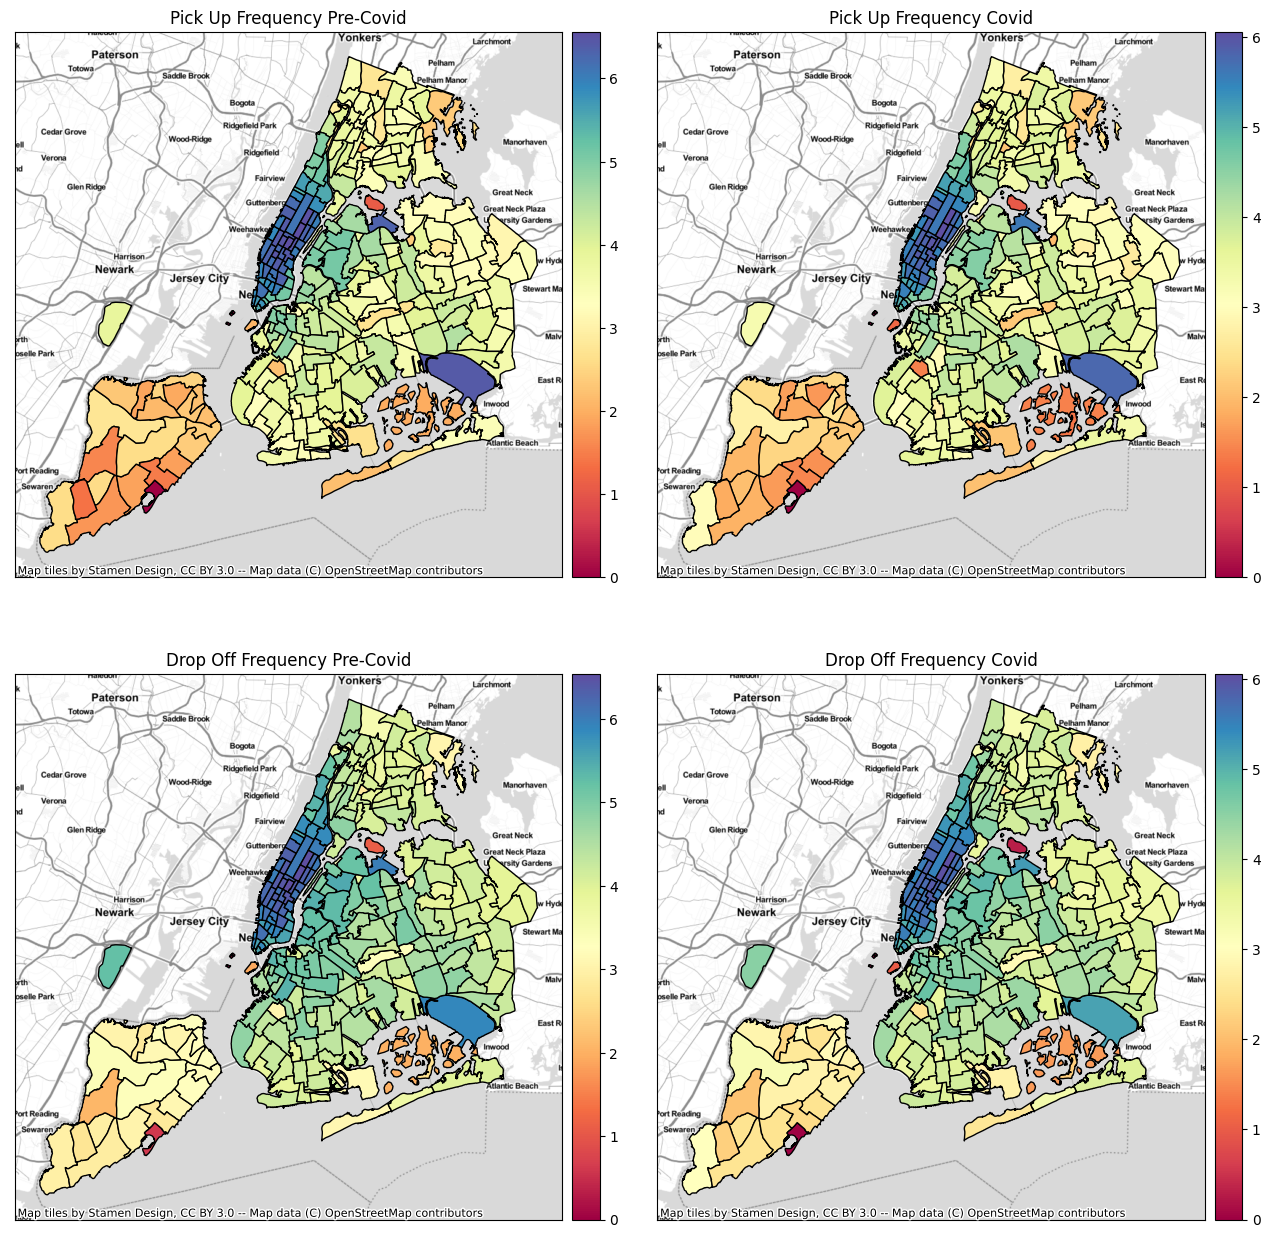

In [6]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, ax = plt.subplots(2, 2, figsize=(13, 13))

fig.tight_layout()

title_array = np.array(
    [['Pick Up Frequency Pre-Covid', 'Pick Up Frequency Covid'],
     ['Drop Off Frequency Pre-Covid', 'Drop Off Frequency Covid']]
)

colour_array = np.array(
    [['PUFrequencyPrC', 'PUFrequencyC'], 
     ['DOFrequencyPrC', 'DOFrequencyC']]
)

data_wm = data.to_crs(epsg=3857)

for row in range(2):
    for column in range(2):
        ax[row, column].title.set_text(title_array[row, column])
        
        ax[row, column].set_xticks([])
        ax[row, column].set_yticks([])
        
        coloured_map = data_wm.plot(
            cmap='Spectral',
            column=colour_array[row, column],
            ax=ax[row, column],
            edgecolor='black',
            legend=True,
            cax=(make_axes_locatable(ax[row, column])
                 .append_axes("right", size="5%", pad=0.1))
        )

        cx.add_basemap(coloured_map, source=cx.providers.Stamen.TonerLite)

plt.show()